In [139]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import time

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### 【問題1】2次元畳み込み層の作成

In [140]:
"""
確率的勾配降下法
"""
class SGD:
    
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

"""
ガウス分布によるシンプルな初期化
"""
class SimpleInitializer:

    def __init__(self, sigma):
        self.sigma = sigma
    
    def W(self, *shape):
        return self.sigma * np.random.randn(*shape)
    
    def B(self, *shape):
        return self.sigma * np.random.randn(*shape)

In [141]:
"""
2次元畳み込み層
"""
class Conv2d_3:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, st=1):
        self.optimizer = optimizer
        if type(filter_size) == int:
            self.filter_size_h = self.filter_size_w = filter_size
        else:
            self.filter_size_h = filter_size[0]
            self.filter_size_w = filter_size[1]
        if type(pa) == int:
            self.pa_h = self.pa_w = pa
        else:
            self.pa_h = pa[0]
            self.pa_w = pa[1]
        if type(st) == int:
            self.st_h = self.st_w = st
        else:
            self.st_h = st[0]
            self.st_w = st[1]
        self.W = initializer.W(n_out_channels, n_in_channels, self.filter_size_h, self.filter_size_w)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out_h = None
        self.n_out_w = None
    
    """
    フォワードプロパゲーション
    ----------
    X : shape (n_samples, n_in_channels, n_in_h, n_in_w)
    A : shape (n_samples, n_out_channels, n_out_h, n_out_w)
    """
    def forward(self, X):
        self.n_samples = X.shape[0]
        self.n_in_h = X.shape[-2]
        self.n_in_w = X.shape[-1]
        self.n_out_h = self.out_size(self.n_in_h, self.filter_size_h, self.pa_h, self.st_h)
        self.n_out_w = self.out_size(self.n_in_w, self.filter_size_w, self.pa_w, self.st_w)
        
        # Xをフィルターの大きさに合わせてパディング
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in_h, self.n_in_w) # 念の為
        self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size_h-1),0), ((self.filter_size_w-1), 0)))        
        
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.filter_size_h, self.filter_size_w, self.n_in_h+(self.filter_size_h-1), self.n_in_w+(self.filter_size_w-1)))
        
        for i in range(self.filter_size_h):
            for j in range(self.filter_size_w):
                self.X1[:, :, i, j] = np.roll(self.X, (-i, -j), axis=(-2, -1))
                
        # print(self.X1[:, np.newaxis, :, :, :, self.filter_size_h-1-self.pa_h:self.n_in_h+self.pa_h:self.st_h, self.filter_size_w-1-self.pa_w:self.n_in_w+self.pa_w:self.st_w])        
        A = np.sum(self.X1[:, np.newaxis, :, :, :, self.filter_size_h-1-self.pa_h:self.n_in_h+self.pa_h:self.st_h, self.filter_size_w-1-self.pa_w:self.n_in_w+self.pa_w:self.st_w]*self.W[:, :, :, :, np.newaxis, np.newaxis], axis=(2, 3, 4)) + self.B.reshape(-1,1,1)
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        ----------
        dA : shape (n_samples, n_out_channels, n_out_h, n_out_w)
        ----------
        dX : shape (n_samples, n_in_channels, n_in_h, n_in_w)
        """
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, :, self.filter_size_h-1-self.pa_h:self.n_in_h+self.pa_h:self.st_h, self.filter_size_w-1-self.pa_w:self.n_in_w+self.pa_w:self.st_w], axis=(0, -2, -1))
        self.dB = np.sum(dA, axis=(0, -2, -1))
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.filter_size_h-1)), (0, (self.filter_size_w-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.filter_size_h, self.filter_size_w, self.dA.shape[-2], self.dA.shape[-1]))
        for i in range(self.filter_size_h):
            for j in range(self.filter_size_w):
                self.dA1[:, :, i, j] = np.roll(self.dA, (i, j), axis=(-2, -1))
        dX = np.sum(self.W[:, :, :, :, np.newaxis, np.newaxis]*self.dA1[:, :, np.newaxis, np.newaxis], axis=(1,4,5))
        
        self.optimizer.update(self)
        return dX
    
    """
    【問題3】2次元畳み込み後の出力サイズ
    """
    def out_size(self, in_size, f, p=0, s=1): 
        return int((in_size+2*p-f) // s) + 1

### 【問題2】小さな配列での2次元畳み込み層の実験

In [142]:
conv2d_3 = Conv2d_3(filter_size=[1, 3], initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=1, n_out_channels=1, pa=[0, 0])

In [143]:
x = np.array([[[[1,5,0,2,8,1], [1,5,0,2,8,1]]], [[[1,5,0,2,8,1], [1,5,0,2,8,1]]]])
conv2d_3.W = np.array([[[[-1, 2, -1]]]], dtype=float)
conv2d_3.B = np.array([0], dtype=float)

print(x.shape)
print(conv2d_3.W.shape)

(2, 1, 2, 6)
(1, 1, 1, 3)


In [144]:
x

array([[[[1, 5, 0, 2, 8, 1],
         [1, 5, 0, 2, 8, 1]]],


       [[[1, 5, 0, 2, 8, 1],
         [1, 5, 0, 2, 8, 1]]]])

In [145]:
a = conv2d_3.forward(x)
print(a)

[[[[ 9. -7. -4. 13.]
   [ 9. -7. -4. 13.]]]


 [[[ 9. -7. -4. 13.]
   [ 9. -7. -4. 13.]]]]


In [146]:
delta_a = np.array([[[[1,2,3,4], [1,2,3,4]]], [[[1,2,3,4], [1,2,3,4]]]])
delta_x = conv2d_3.backward(delta_a)
delta_x

array([[[[[-1.,  0.,  0.,  0.,  5., -4.],
          [-1.,  0.,  0.,  0.,  5., -4.]]]],



       [[[[-1.,  0.,  0.,  0.,  5., -4.],
          [-1.,  0.,  0.,  0.,  5., -4.]]]]])

In [147]:
delta_w = conv2d_3.dW
delta_b = conv2d_3.dB
delta_w, delta_b

(array([[[[ 76., 172., 128.]]]]), array([40]))

### 【問題4】最大プーリング層の作成

In [151]:
class MaxPool2D:
    def __init__(self, st):
        self.st_h = st[0]
        self.st_w = st[1]
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_in_channels, n_in_h, n_in_w)
            入力
        """
        self.X = X
        self.n_samples, self.n_in_channels, self.n_in_h, self.n_in_w = X.shape
        A = np.zeros((self.n_samples, self.n_in_channels, self.n_in_h//self.st_h, self.n_in_w//self.st_w))
        self.Aij = np.zeros(((self.n_in_h*self.n_in_w)//(self.st_h*self.st_w), X.ndim), dtype=int)
        for t in range(self.n_samples):
            for m in range(self.n_in_channels):
                for i in range(self.n_in_h//self.st_h):
                    for j in range(self.n_in_w//self.st_w):
                        X1 = X[t, m, i*self.st_h:(i+1)*self.st_h, j*self.st_w:(j+1)*self.st_w]
                        A[t, m, i, j] = np.max(X1)
                        idx = np.argmax(X1)
                        self.Aij[i*(self.n_in_w//self.st_w) + j] = np.array([t, m, i*self.st_h + idx//self.st_h, j*self.st_w + idx%self.st_h], dtype=int)
        return A
    
    def backward(self, dA):
        a = np.zeros(self.X.shape)
        a[tuple(self.Aij.T)] = 1
        return a*dA

In [152]:
maxpool2d = MaxPool2D([2,2])
print(maxpool2d.forward(np.arange(1*1*6*8).reshape(1,1,6,8)))
print(maxpool2d.Aij)

[[[[ 9. 11. 13. 15.]
   [25. 27. 29. 31.]
   [41. 43. 45. 47.]]]]
[[0 0 1 1]
 [0 0 1 3]
 [0 0 1 5]
 [0 0 1 7]
 [0 0 3 1]
 [0 0 3 3]
 [0 0 3 5]
 [0 0 3 7]
 [0 0 5 1]
 [0 0 5 3]
 [0 0 5 5]
 [0 0 5 7]]


In [153]:
maxpool2d.backward(np.arange(1*1*6*8).reshape(1,1,6,8))

array([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  9.,  0., 11.,  0., 13.,  0., 15.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 25.,  0., 27.,  0., 29.,  0., 31.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 41.,  0., 43.,  0., 45.,  0., 47.]]]])

### 【問題6】平滑化

In [154]:
class Flatten:
    
    def forward(self, A):
        self.n_samples, self.n_out_channels, self.n_out_h, self.n_out_w = A.shape
        return A.reshape(self.n_samples, -1)
    
    def backward(self, dA):
        return dA.reshape(self.n_samples, self.n_out_channels, self.n_out_h, self.n_out_w)

### 【問題7】学習と推定

In [155]:
class ActSigmoid:
    
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class ActTanh:
    
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class ActSoftmax:
    
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    
    def loss_func(self, Y, Z=None):
        """
        y_true : (n_samples, n_output)
        z : (n_samples, n_output)
        """
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))

class ActReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

class ScratchConvNeuralNetrowkClassifier:
    
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, 
                 n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                 verbose=True, Activater=ActTanh, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.batch_size = batch_size # バッチサイズ
        self.n_features = n_features # 特徴量の数
        # self.n_nodes1 = n_nodes1 # 1層目のノード数 # self.conv2d_3.n_out になる
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        
        self.Activater = Activater
        if Activater == ActSigmoid or Activater == ActTanh:
            self.Initializer = XavierInitializer
        elif Activater == ActReLU:
            self.Initializer = HeInitializer
        else:
            print("活性化関数が不適切")
        self.Optimizer = Optimizer
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.val_enable = False
        if X_val is not None:
            self.val_enable = True
        
        #optimizer = self.Optimizer(self.lr)
        self.conv2d_3 = Conv2d_3(filter_size=[7, 7], initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), n_in_channels=1, n_out_channels=1, pa=[3, 3], st=[2, 2])
        self.conv2d_3.n_out_h = out_size(X.shape[-2], self.conv2d_3.filter_size_h, self.conv2d_3.pa_h, self.conv2d_3.st_h)
        self.conv2d_3.n_out_w = out_size(X.shape[-1], self.conv2d_3.filter_size_w, self.conv2d_3.pa_w, self.conv2d_3.st_w)
        self.flatten = Flatten()
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.conv2d_3.n_out_h*self.conv2d_3.n_out_w, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = ActSoftmax()
        
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        
        for i in range(self.num_epoch):
            time0 = time.time()
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            self.iter = len(get_mini_batch)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_X, mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))
            print("epoch[", i+1, "] : ", round(time.time()-time0, 2), "(s)", sep="")
        
        if self.verbose:
            self.learning_curve()
            print()
        
    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)
    
    def forward_propagation(self, X):
        A1 = self.conv2d_3.forward(X)
        A1 = self.flatten.forward(A1)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
        
    def back_propagation(self, X, y_true):
        dA3 = self.activation3.backward(y_true) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = self.flatten.backward(dA1)
        dZ0 = self.conv2d_3.backward(dA1) # dZ0は使用しない
    
    def learning_curve(self):
        plt.title("model loss")
        plt.xlabel("num_epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(1, self.num_epoch*self.iter + 1), self.loss, label="train_loss")
        plt.plot(np.arange(0, self.num_epoch + 1)*self.iter, self.loss_epoch, label="epoch_loss")
        if self.val_enable:
            plt.plot(np.arange(1, self.num_epoch + 1), self.val_loss, label="val_loss")
        plt.legend()
        plt.show()
        return

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = X@self.W + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [164]:
def evaluate(y_true, y_pred):
    print("  accuracy =", accuracy_score(y_true, y_pred))
    print("  precision =", precision_score(y_true, y_pred, average='macro'))
    print("  recall =", recall_score(y_true, y_pred, average='macro'))
    print("  f1 =", f1_score(y_true, y_pred, average='macro'))
    # print(confusion_matrix(y_true, y_pred))

In [157]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
# print(y_train.shape) # (60000,)
# print(y_train_one_hot.shape) # (60000, 10)
# print(y_train_one_hot.dtype) # float64
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
# print("X_train.shape =", X_train_.shape) # (48000, 784)
# print("X_val.shape =", X_val.shape) # (12000, 784)
# print("y_train.shape =", y_train_.shape) # (48000, 784)
# print("y_val.shape =", y_val.shape) # (12000, 784)

epoch[1] : 83.06(s)
epoch[2] : 86.93(s)
epoch[3] : 85.74(s)
epoch[4] : 90.05(s)
epoch[5] : 85.54(s)
epoch[6] : 88.79(s)
epoch[7] : 88.04(s)
epoch[8] : 89.37(s)
epoch[9] : 93.62(s)
epoch[10] : 92.36(s)
epoch[11] : 92.35(s)
epoch[12] : 93.02(s)
epoch[13] : 91.27(s)
epoch[14] : 89.74(s)
epoch[15] : 88.86(s)
epoch[16] : 89.72(s)
epoch[17] : 95.17(s)
epoch[18] : 92.67(s)
epoch[19] : 93.25(s)
epoch[20] : 92.13(s)
epoch[21] : 88.92(s)
epoch[22] : 90.34(s)
epoch[23] : 89.87(s)
epoch[24] : 92.98(s)
epoch[25] : 92.12(s)
epoch[26] : 90.41(s)
epoch[27] : 90.07(s)
epoch[28] : 89.2(s)
epoch[29] : 92.91(s)
epoch[30] : 87.98(s)


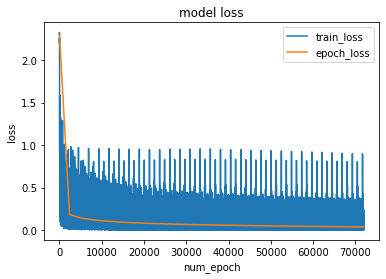

In [158]:
scratch_cnn1 = ScratchConvNeuralNetrowkClassifier(num_epoch=30, lr=0.01, batch_size=20, 
                                                  n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                                                  verbose=True, Activater=ActReLU, Optimizer=AdaGrad)
scratch_cnn1.fit(X_train_, y_train_)

In [165]:
y_pred1 = scratch_cnn1.predict(X_test)
evaluate(y_test, y_pred1)

  accuracy = 0.9754
  precision = 0.9754076376601164
  recall = 0.9750523062551611
  f1 = 0.9751868549142453


### 【問題10】出力サイズとパラメータ数の計算


入力サイズ : 144×144, 3チャンネル  
フィルタサイズ : 3×3, 6チャンネル  
ストライド : 1  
パディング : なし  
→ 出力サイズ : 142×142, 6チャンネル  
→ パラメータサイズ : 54  


入力サイズ : 60×60, 24チャンネル  
フィルタサイズ : 3×3, 48チャンネル  
ストライド　: 1  
パディング : なし  
→ 出力サイズ : 58×58, 48チャンネル  
→ パラメータサイズ : 432  


入力サイズ : 20×20, 10チャンネル  
フィルタサイズ: 3×3, 20チャンネル  
ストライド : 2  
パディング : なし  
→ 出力サイズ : 9×9, 20チャンネル  
→ パラメータサイズ : 180  